In [1]:
# Step 1: Load and preprocess the data
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
import kagglehub
import matplotlib.pyplot as plt 
import seaborn as sns   

# Download latest version of the dataset
path = kagglehub.dataset_download("shivanandmn/multilabel-classification-dataset")

print("Path to dataset files:", path)

# Load the dataset
url_train = f'{path}/train.csv'
train_set  = pd.read_csv(url_train)

Path to dataset files: /home/lolli/.cache/kagglehub/datasets/shivanandmn/multilabel-classification-dataset/versions/1


In [2]:
train_set.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [3]:

train_set.drop(columns=['ID'], inplace=True)
# Preprocess the data

# Combine the category columns into a list of categories for each paper
categories = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
train_set['Categories'] = train_set[categories].apply(lambda row: [cat for cat in categories if row[cat] == 1], axis=1)

train_set.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Categories
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,[Computer Science]
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,[Computer Science]
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,[Mathematics]
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,[Mathematics]
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,"[Computer Science, Statistics]"


/tmp/ipykernel_12474/3792989851.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


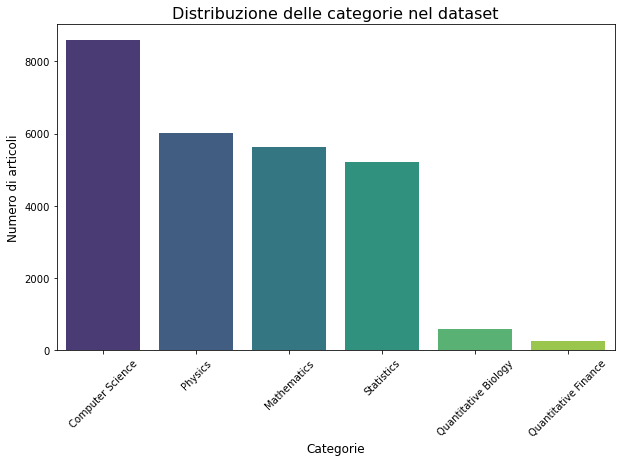

Number of occurrency for each category:
Computer Science: 8594
Physics: 6013
Mathematics: 5618
Statistics: 5206
Quantitative Biology: 587
Quantitative Finance: 249


In [4]:
# 1. Visualizzazione della distribuzione delle categorie
category_counts = train_set[categories].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title("Distribuzione delle categorie nel dataset", fontsize=16)
plt.ylabel("Numero di articoli", fontsize=12)
plt.xlabel("Categorie", fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Stampa del numero di occorrenze per ogni categoria
print("Number of occurrency for each category:")
for category, count in category_counts.items():
    print(f"{category}: {count}")

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Flatten the list of categories
flattened_categories = train_set['Categories'].explode()

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(flattened_categories), y=flattened_categories)

# Create a dictionary mapping each category to its weight
class_weight_dict = {category: weight for category, weight in zip(np.unique(flattened_categories), class_weights)}

print("Class weights:", class_weight_dict)

# Apply class weights to the classifier
classifier_balanced = LogisticRegression(class_weight=class_weight_dict)

Class weights: {'Computer Science': 0.5094057869831665, 'Mathematics': 0.779251216328468, 'Physics': 0.7280614224735296, 'Quantitative Biology': 7.457978421351505, 'Quantitative Finance': 17.581659973226238, 'Statistics': 0.8409207324881547}


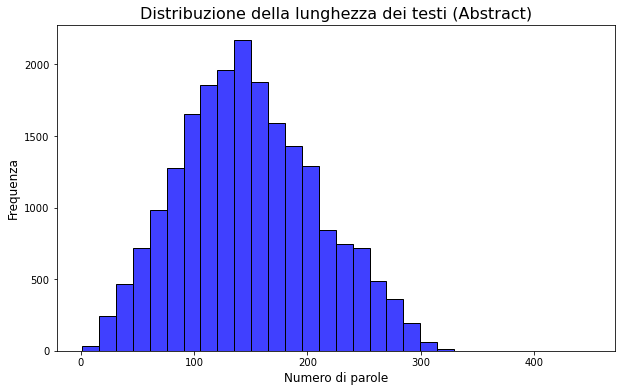

In [6]:
# 2. Esplorazione della lunghezza dei testi
# Aggiungiamo una colonna che rappresenta la lunghezza dell'abstract
train_set['Text_Length'] = train_set['ABSTRACT'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_set['Text_Length'], bins=30, color='blue')
plt.title("Distribuzione della lunghezza dei testi (Abstract)", fontsize=16)
plt.xlabel("Numero di parole", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.show()

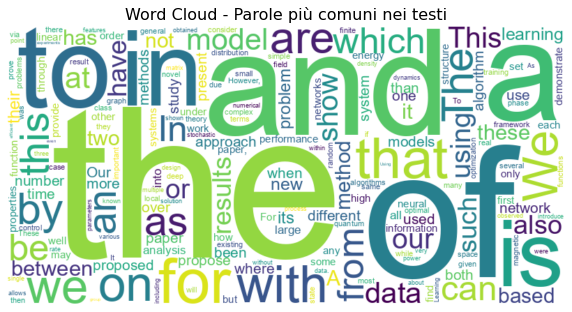

In [7]:
from wordcloud import WordCloud
from collections import Counter

train_set['TEXT'] = train_set['TITLE'] + ' ' + train_set['ABSTRACT']

# Uniamo tutti I TEXT
all_text = " ".join(str(text) for text in train_set['TEXT'])

# Troviamo le parole più comuni
word_freq = Counter(all_text.split())

# Creiamo una WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    font_path="./ARIAL.TTF"  # Specifica il font
).generate_from_frequencies(word_freq)

# Mostra la WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Parole più comuni nei testi", fontsize=16)
plt.show()

In [8]:
contractions_dict = {
    "don't": "do not",
    "doesn't": "does not",
    "can't": "cannot",
    "isn't": "is not",
    "won't": "will not",
    "wasn't": "was not",
    "weren't": "were not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "it's": "it is",
    "I'm": "I am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "we're": "we are",
    "they're": "they are",
    "I've": "I have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "I'll": "I will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "I'd": "I would",
    "you'd": "you would",
    "he'd": "he would",
    "she'd": "she would",
    "we'd": "we would",
    "they'd": "they would",
    "I won't": "I will not",
    "you won't": "you will not",
    "he won't": "he will not",
    "she won't": "she will not",
    "we won't": "we will not",
    "they won't": "they will not",
}


def expand_contractions(text, contractions_dict):
    for contraction, expansion in contractions_dict.items():
        text = text.replace(contraction, expansion)
    return text



In [9]:
import nltk
from nltk.corpus import stopwords
import re

# Preprocess the text data
train_set['TITLE'] = train_set['TITLE'].str.lower().str.replace(r'[^\\w\\s]', '').str.replace(r'\\d+', '').str.strip()
train_set['ABSTRACT'] = train_set['ABSTRACT'].str.lower().str.replace(r'[^\\w\\s]', '').str.replace(r'\\d+', '').str.strip()
train_set['PROCESSED_TEXT'] = train_set['TITLE'] + ' ' + train_set['ABSTRACT']

# Scarica il set di stop words in italiano o ingles
#nltk.download('stopwords')

# Stop words in inglese
stop_words = set(nltk.corpus.stopwords.words('english'))

# Funzione per rimuovere stop words
def remove_stop_words(text):
    # Tokenizza il testo, rimuove stop words e parole corte
    words = " ".join([contractions_dict.get(word, word) for word in text.split()])
    words = [word for word in text.split() if word not in stop_words and len(word) > 1]
    
    return " ".join(words)

# Applica la funzione alla colonna 'text' o 'ABSTRACT'
train_set['PROCESSED_TEXT'] = train_set['PROCESSED_TEXT'].apply(lambda x: expand_contractions(x, contractions_dict))
train_set['PROCESSED_TEXT'] = train_set['PROCESSED_TEXT'].apply(remove_stop_words)

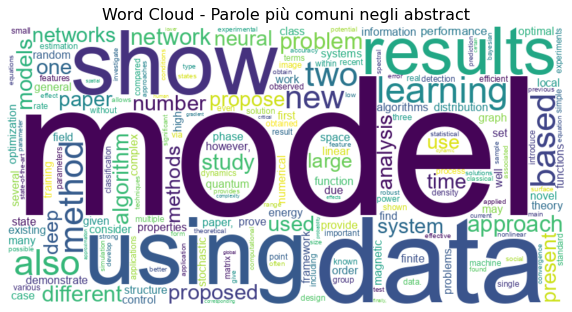

In [10]:
# Uniamo tutti gli abstract
all_text = " ".join(str(text) for text in train_set['PROCESSED_TEXT'])

# Troviamo le parole più comuni
word_freq = Counter(all_text.split())

# Creiamo una WordCloud
wordcloud2 = WordCloud(
    width=800,
    height=400,
    background_color="white",
    font_path="./ARIAL.TTF"  # Specifica il font
).generate_from_frequencies(word_freq)

# Mostra la WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Parole più comuni negli abstract", fontsize=16)
plt.show()

In [11]:

# Binarize the labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train_set['Categories'])

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(train_set['TEXT'])


In [12]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1]])

In [13]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1852623 stored elements and shape (20972, 10000)>

In [14]:

# Step 2: Implement a machine learning classifier
classifier = LogisticRegression()


In [15]:

from sklearn.multiclass import OneVsRestClassifier

# Step 3: Evaluate the classifier using suitable metrics
kf = KFold(n_splits=5, shuffle=True)
f1_scores = []
accuracy_scores = []

ovr_classifier = OneVsRestClassifier(classifier)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ovr_classifier.fit(X_train, y_train)
    y_pred = ovr_classifier.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred, average='micro'))
    accuracy_scores.append(accuracy_score(y_test, y_pred))


In [16]:

# Step 4: Split data for k-fold cross-validation
# (Already done in the loop above)

# Step 5: Run the evaluation
print("F1 Scores: ", f1_scores)


F1 Scores:  [0.8010610079575596, 0.7999594854654107, 0.8064810126582278, 0.8034952245478562, 0.8132204427216159]


In [17]:
print("Accuracy Scores: ", accuracy_scores)

# Step 6: Compare with dedicated baselines
# (Assuming we have baseline scores to compare with)

# Step 7: Analyze the obtained results
print("Average F1 Score: ", sum(f1_scores) / len(f1_scores))
print("Average Accuracy Score: ", sum(accuracy_scores) / len(accuracy_scores))

Accuracy Scores:  [0.6469606674612635, 0.6421930870083432, 0.6497377205531712, 0.6580829756795422, 0.6702432045779685]
Average F1 Score:  0.804843434670134
Average Accuracy Score:  0.6534435310560578


In [18]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import wordnet as wn
import nltk

# Scarica risorse necessarie
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# Inizializza il lemmatizzatore
lemmatizer = WordNetLemmatizer()

# Funzione per ottenere il tag di WordNet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('V'):
        return wn.VERB
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN

# Funzione per lemmatizzare il testo
def lemmatize_text(text):
    words = text.split()
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return " ".join(lemmatized_words)

# Applica la lemmatizzazione alla colonna Processed_Text
train_set['LEMMATIZED_TEXT'] = train_set['PROCESSED_TEXT'].apply(lemmatize_text)

# Visualizza il risultato
print(train_set[['PROCESSED_TEXT', 'LEMMATIZED_TEXT']])

[nltk_data] Downloading package wordnet to /home/lolli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/lolli/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/lolli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


                                          PROCESSED_TEXT  \
0      reconstructing subject-specific effect maps pr...   
1      rotation invariance neural network rotation in...   
2      spherical polyharmonics poisson kernels polyha...   
3      finite element approximation stochastic maxwel...   
4      comparative study discrete wavelet transforms ...   
...                                                  ...   
20967  contemporary machine learning: guide practitio...   
20968  uniform diamond coatings wc-co hard alloy cutt...   
20969  analysing soccer games clustering conceptors p...   
20970  efficient simulation left-tail sum correlated ...   
20971  optional stopping problem bayesians recently, ...   

                                         LEMMATIZED_TEXT  
0      reconstruct subject-specific effect map predic...  
1      rotation invariance neural network rotation in...  
2      spherical polyharmonics poisson kernel polyhar...  
3      finite element approximation stochas

In [19]:

# Binarize the labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(train_set['Categories'])

# Vectorize the text data
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(train_set['LEMMATIZED_TEXT'])

In [20]:
y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 1]])

In [21]:

# Step 2: Implement a machine learning classifier
classifier = LogisticRegression()

In [22]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import recall_score

# Step 3: Evaluate the classifier using suitable metrics
kf = KFold(n_splits=5, shuffle=True)
f1_scores = []
accuracy_scores = []
recall_scores = []

ovr_classifier = OneVsRestClassifier(classifier)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ovr_classifier.fit(X_train, y_train)
    y_pred = ovr_classifier.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred, average='micro'))
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred, average='micro'))


In [23]:
# Step 4: Split data for k-fold cross-validation
# (Already done in the loop above)

# Step 5: Run the evaluation
print("F1 Scores: ", f1_scores)
print("Recall Scores: ", recall_scores)

F1 Scores:  [0.7843017329255861, 0.7798016595830803, 0.7921055322630126, 0.7902557363792581, 0.7848896090743367]
Recall Scores:  [0.7355640535372849, 0.7295966672978602, 0.7438064144420972, 0.7417457305502846, 0.7340405379806781]


In [24]:
print("Accuracy Scores: ", accuracy_scores)

# Step 6: Compare with dedicated baselines
# (Assuming we have baseline scores to compare with)

# Step 7: Analyze the obtained results
print("Average F1 Score: ", sum(f1_scores) / len(f1_scores))
print("Average Accuracy Score: ", sum(accuracy_scores) / len(accuracy_scores))
print("Average Recall Score: ", sum(recall_scores) / len(recall_scores))

Accuracy Scores:  [0.6247914183551847, 0.6159713945172824, 0.6363853123509776, 0.6278016213638531, 0.6225560324272771]
Average F1 Score:  0.7862708540450548
Average Accuracy Score:  0.6255011558029151
Average Recall Score:  0.7369506807616409
